In [1]:
import joblib

X_train, X_test, y_train, y_test = joblib.load('artifacts/final_census_data.pkl')

In [2]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.base import ClassifierMixin

def evaluate_model(model: ClassifierMixin, X_test, y_test, name=None):
    # Predict labels
    y_pred = model.predict(X_test)
    
    # Predict probabilities / scores
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = None

    # Collect metrics
    metrics = {
        "Model": name if name else model.__class__.__name__,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred, average='weighted'),
    }
    if y_proba is not None:
        metrics["ROC-AUC"] = roc_auc_score(y_test, y_proba)
    
    return metrics, y_pred, y_proba

In [3]:
results = {}
y_probas = {}
ap_scores = {}  # store average precision

In [5]:
from sklearn.metrics import average_precision_score

def add_evaluation(model: ClassifierMixin, X_test, y_test, name=None):
    # Get probabilities or decision function
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)

    # Save
    y_probas[name] = y_scores
    ap_scores[name] = average_precision_score(y_test, y_scores)

# Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression

model_name = "Logistic Regression"
lr_model = LogisticRegression(max_iter=10_000, random_state=42)
lr_model.fit(X_train, y_train)

metrics, y_pred, y_proba = evaluate_model(lr_model, X_test, y_test, model_name)
results[model_name] = metrics

add_evaluation(lr_model, X_test, y_test, model_name)

In [7]:
results["Logistic Regression"]

{'Model': 'Logistic Regression',
 'Accuracy': 0.7588392261507672,
 'Precision': 0.5049465769687377,
 'Recall': 0.86743711760707,
 'F1': 0.7747598153800581,
 'ROC-AUC': 0.8787704083740531}

# Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

model_name = "Random Forest"
metrics, y_pred, y_proba = evaluate_model(rf_model, X_test, y_test, model_name)
results[model_name] = metrics

add_evaluation(rf_model, X_test, y_test, model_name)

In [10]:
results["Random Forest"]

{'Model': 'Random Forest',
 'Accuracy': 0.8105403602401601,
 'Precision': 0.5804901489668428,
 'Recall': 0.8212100611828688,
 'F1': 0.8199621268084761,
 'ROC-AUC': 0.8949597184611514}

Use F1-score

Why: Balances precision and recall, so it doesn’t favor the majority class.

When: After SMOTE, classes are balanced in training, but your test set should stay imbalanced — so the F1 gives a fairer view.

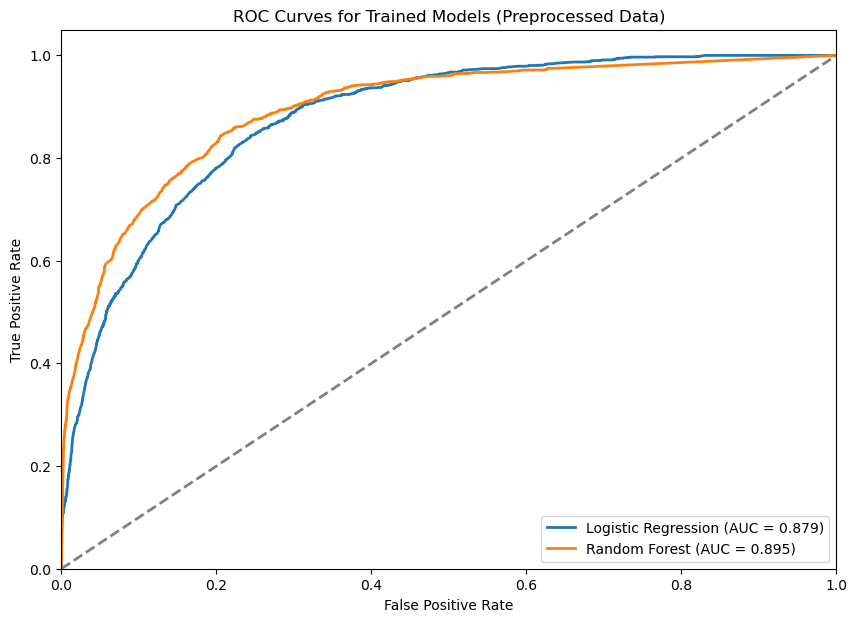

In [11]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 7))

for name, y_proba in y_probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

# Baseline (random classifier)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Trained Models (Preprocessed Data)")
plt.legend(loc="lower right")
plt.show()

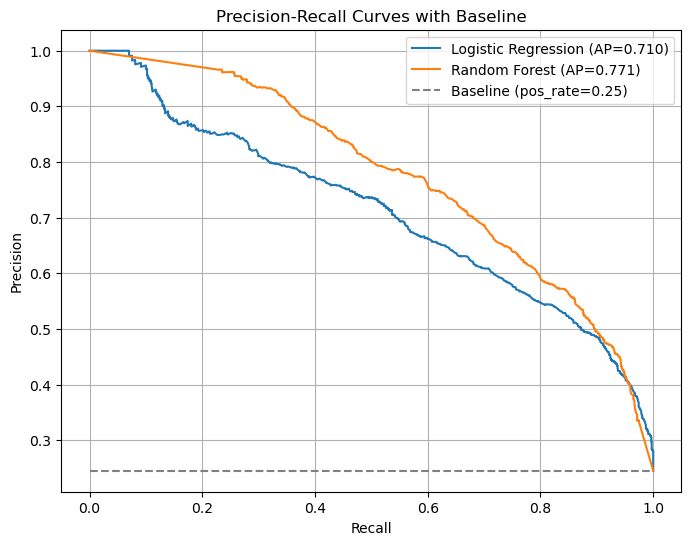

In [12]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Proportion of positive class in test set
pos_rate = np.mean(y_test)

plt.figure(figsize=(8,6))
for name, y_scores in y_probas.items():
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

# Add baseline
plt.hlines(pos_rate, 0, 1, colors="gray", linestyles="--", label=f"Baseline (pos_rate={pos_rate:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves with Baseline")
plt.legend()
plt.grid(True)
plt.show()

# Classification Report

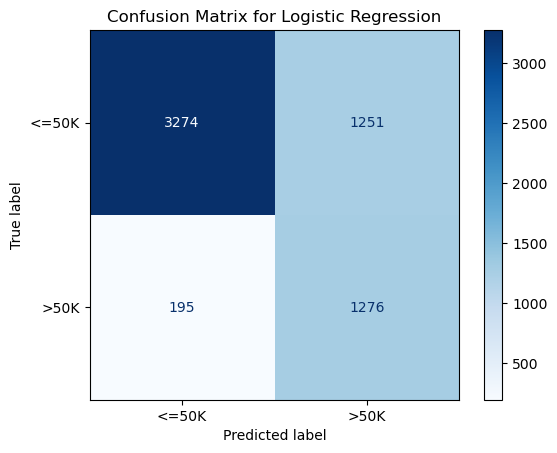

In [13]:
# Plot classification matrix on test data for both models
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
    lr_model,
    X_test,
    y_test,
    display_labels=["<=50K", ">50K"],
    cmap=plt.cm.Blues,
    normalize=None
)
disp.ax_.set_title(f"Confusion Matrix for Logistic Regression")
plt.show()

In [14]:
from sklearn.metrics import classification_report

y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.72      0.82      4525
           1       0.50      0.87      0.64      1471

    accuracy                           0.76      5996
   macro avg       0.72      0.80      0.73      5996
weighted avg       0.84      0.76      0.77      5996



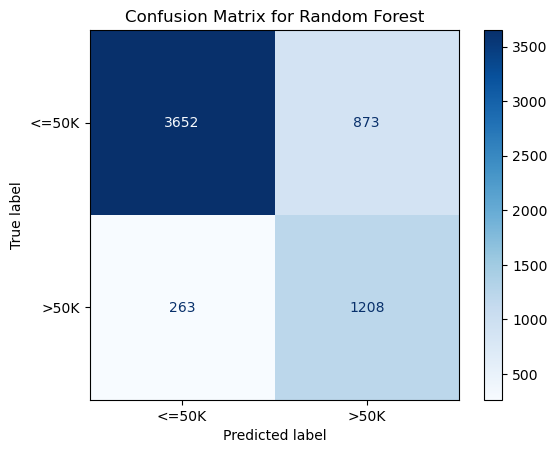

In [15]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_model,
    X_test,
    y_test,
    display_labels=["<=50K", ">50K"],
    cmap=plt.cm.Blues,
    normalize=None
)
disp.ax_.set_title(f"Confusion Matrix for Random Forest")
plt.show()

In [13]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      4525
           1       0.58      0.82      0.68      1471

    accuracy                           0.81      5996
   macro avg       0.76      0.81      0.77      5996
weighted avg       0.85      0.81      0.82      5996



# Hyperparameter Tuning

## Logistic Regression

In [27]:
from sklearn.model_selection import GridSearchCV

# Define base model
log_reg = LogisticRegression(class_weight='balanced', max_iter=10_000, random_state=42)

# Define parameter grid
param_grid_lr = [
    # l2 penalty with lbfgs or saga
    {
        'penalty': ['l2'],
        'solver': ['lbfgs', 'saga'],
        'C': [0.01, 0.1, 1, 10]
    },
    # l1 penalty with liblinear or saga
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'C': [0.01, 0.1, 1, 10]
    },
    # elasticnet only with saga
    {
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.2, 0.5, 0.8],
        'C': [0.01, 0.1, 1, 10]
    }
]

# Grid search with 5-fold cross-validation
grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Best Parameters:", grid_lr.best_params_)
print("Best F1 Score:", grid_lr.best_score_)

Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best F1 Score: 0.8135225647997689


In [28]:
evaluate_model(grid_lr.best_estimator_, X_test, y_test, "Logistic Regression (Grid Search)")[0]

{'Model': 'Logistic Regression (Grid Search)',
 'Accuracy': 0.7623415610406938,
 'Precision': 0.509185303514377,
 'Recall': 0.8667573079537729,
 'F1': 0.777910924552234,
 'ROC-AUC': 0.8788904454818949}

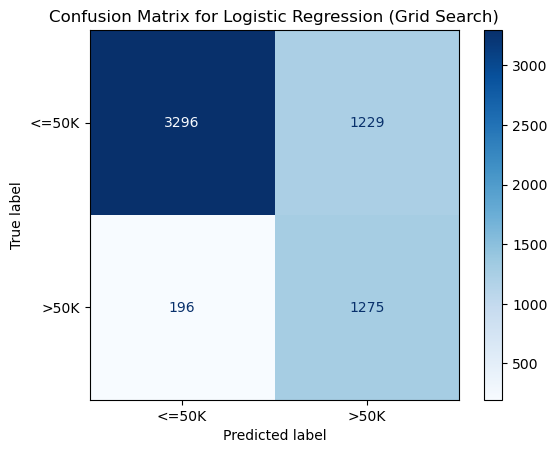

In [26]:
disp = ConfusionMatrixDisplay.from_estimator(
    grid_lr.best_estimator_,
    X_test,
    y_test,
    display_labels=["<=50K", ">50K"],
    cmap=plt.cm.Blues,
    normalize=None
)
disp.ax_.set_title(f"Confusion Matrix for Logistic Regression (Grid Search)")
plt.show()

## Random Forest

In [29]:
#  Grid Search Hyperparameter Tuning (Random Forest)
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [30]:
evaluate_model(best_rf_model, X_test, y_test, "Random Forest (Grid Search)")[0]

{'Model': 'Random Forest (Grid Search)',
 'Accuracy': 0.811707805203469,
 'Precision': 0.5815839694656488,
 'Recall': 0.8286879673691366,
 'F1': 0.8212196954611138,
 'ROC-AUC': 0.9000762438450935}

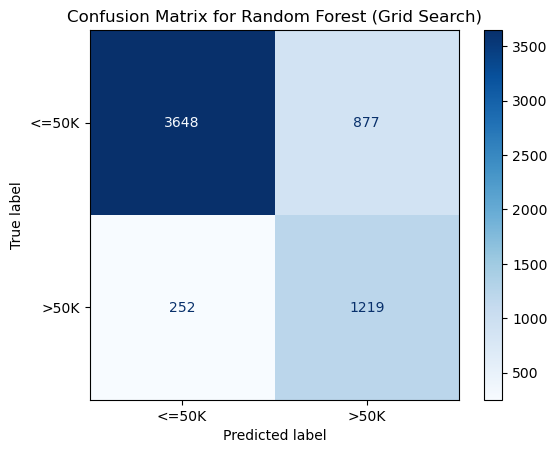

In [31]:
disp = ConfusionMatrixDisplay.from_estimator(
    best_rf_model,
    X_test,
    y_test,
    display_labels=["<=50K", ">50K"],
    cmap=plt.cm.Blues,
    normalize=None
)
disp.ax_.set_title(f"Confusion Matrix for Random Forest (Grid Search)")
plt.show()

In [32]:
y_pred = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4525
           1       0.58      0.83      0.68      1471

    accuracy                           0.81      5996
   macro avg       0.76      0.82      0.77      5996
weighted avg       0.85      0.81      0.82      5996

